In [79]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import time

def load_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0)

def evaluate_backbone(model, img_tensor):
    model.eval()
    with torch.no_grad():
        start = time.time()
        features = model(img_tensor)
        end = time.time()
    num_params = sum(p.numel() for p in model.parameters())
    print(f"Backbone: {model.__class__.__name__}")
    print(f"Inference time: {end - start:.4f} s")
    print(f"Output shape: {features.shape}")
    print(f"Number of parameters: {num_params}\n")

img_tensor = load_image("https://images.unsplash.com/photo-1503023345310-bd7c1de61c7d")

resnet50 = models.resnet50(pretrained=True)
efficientnet_b0 = models.efficientnet_b0(pretrained=True)

evaluate_backbone(resnet50, img_tensor)
evaluate_backbone(efficientnet_b0, img_tensor)


Backbone: ResNet
Inference time: 0.0261 s
Output shape: torch.Size([1, 1000])
Number of parameters: 25557032

Backbone: EfficientNet
Inference time: 0.2914 s
Output shape: torch.Size([1, 1000])
Number of parameters: 5288548



In [91]:
list(resnet50.modules()) 
import torch.nn as nn
resnet50_without_last_classifier = torch.nn.Sequential(*(list(resnet50.children())[:-1]))
num_params = sum(p.numel() for p in resnet50_without_last_classifier.parameters())
num_params


23508032

In [92]:
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [95]:
resnet50_without_last_classifier.eval()
with torch.no_grad():
    features = resnet50_without_last_classifier(img_tensor)
features.shape

torch.Size([1, 2048, 1, 1])

Feature map shape: torch.Size([1, 64, 56, 56])


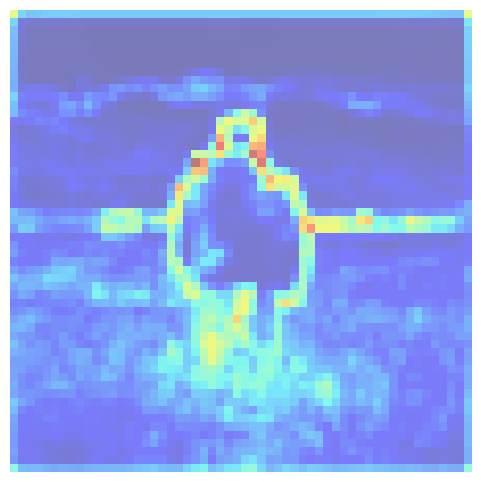

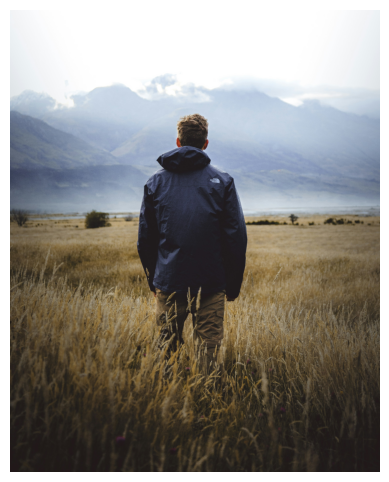

In [123]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

def load_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0), img

resnet = models.resnet50(pretrained=True)

backbone = torch.nn.Sequential(*list(resnet.children())[:-6])
backbone.eval()

img_tensor, original_img = load_image("https://images.unsplash.com/photo-1503023345310-bd7c1de61c7d")

with torch.no_grad():
    feature_map = backbone(img_tensor)

print("Feature map shape:", feature_map.shape)


heatmap = feature_map.squeeze(0).mean(0).numpy()
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # normalize

plt.figure(figsize=(6,6))
plt.imshow(original_img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # overlay
plt.axis('off')
plt.show()


plt.figure(figsize=(6,6))
plt.imshow(original_img)
plt.axis('off')
plt.show()
